<a href="https://colab.research.google.com/github/AndrewRomitti/DementiaDoctor/blob/main/PYTORCH_ALZHEIMER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents


1.   Importing Data
2.   Exploratory Data Analysis (EDA)
3.   Creating a Custom Dataset & DataLoader
4.   Creating the Model



# Importing Data


---



The dataset being used is the **"Augmented Alzheimer MRI Dataset V2"**

link to dataset:
https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2

This is a pre-augmented data preparation of the original dataset found here:\
https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


Note:\
If results don't meet standard, custom data augmentation may be applied to the original dataset, however for the purpose of this notebook we will use the pre-augmented data


---

For a tutorial on how to upload kaggle datasets into your google colab notebooks follow this tutorial by Varsha.\
https://www.kaggle.com/general/156610

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrewromitti1","key":"afba0c1d61c28adb86401ceb91bee3ad"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                                title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                              Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16          12087        317  1.0              
asahu40/walmart-data-analysis-and-forcasting                       Walmart Data Analysis and Forcasting              122KB  2023-04-26 07:07:03           1789         40  1.0              
ahmedshahriarsakib/usa-real-estate-dataset                         USA Real Estate Dataset                             1MB  2023-04-30 03:51:36           1452         41  1.0              
iammustafatz/diabetes-prediction-dataset               

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset-v2

 99% 375M/379M [00:04<00:00, 132MB/s]
100% 379M/379M [00:04<00:00, 94.8MB/s]


In [ ]:
#!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

In [ ]:
!unzip /content/augmented-alzheimer-mri-dataset-v2.zip

# Exploratory Data Analysis (EDA)


---

Now that the Data is properly imported into google drive we are going to explore it to gain some insights and plans on the model approach we should take

This will involve


*   Plotting data distribution
*   Plotting images
*   Plotting Image Dimensions




In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import fnmatch
import numpy as np
from PIL import Image
import tqdm

Text(0.5, 0, 'Directories')

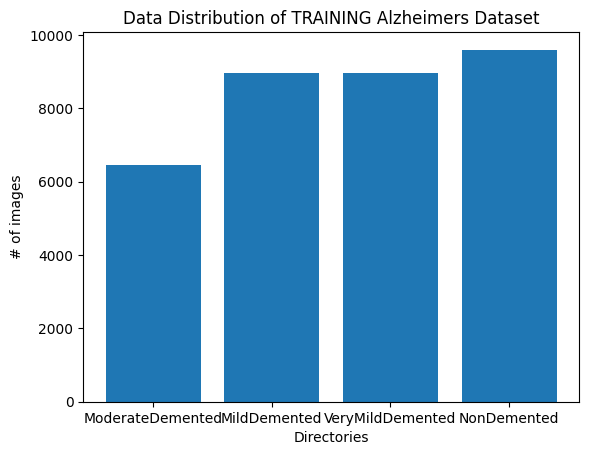

In [ ]:
#Data Distribution for Training
PATH = r"/content/data/train/"

x_axis = [dir for dir in os.listdir(PATH)]
y_axis = []

for dir in os.listdir(PATH):
  target_dir = PATH + "/" + dir
  files = os.listdir(target_dir)
  count = len(files)
  y_axis.append(count)

plt.bar(x_axis, y_axis)
plt.title("Data Distribution of TRAINING Alzheimers Dataset")
plt.ylabel("# of images")
plt.xlabel("Directories")

Text(0.5, 0, 'Directories')

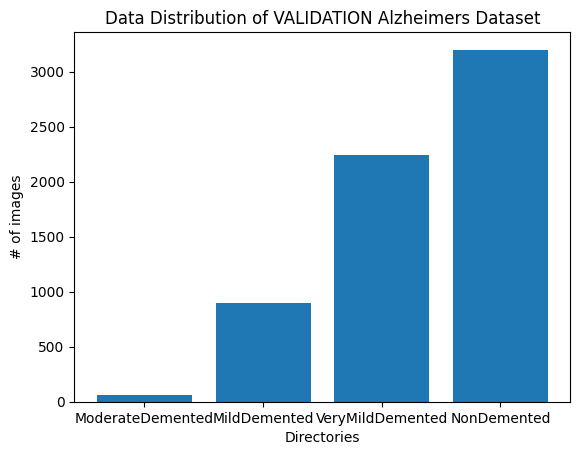

In [ ]:
#Data Distribution for Validation
PATH = r"/content/data/val/"

x_axis = [dir for dir in os.listdir(PATH)]
y_axis = []

for dir in os.listdir(PATH):
  target_dir = PATH + "/" + dir
  files = os.listdir(target_dir)
  count = len(files)
  y_axis.append(count)

plt.bar(x_axis, y_axis)
plt.title("Data Distribution of VALIDATION Alzheimers Dataset")
plt.ylabel("# of images")
plt.xlabel("Directories")

It seems the training data is well distributed as it has been augmented for more images; However, it may be hard to get meaningful testing insights from moderately demented. As far as training this will be adequate for our tasks

In [ ]:
import glob

In [ ]:
PATH = r"/content/data/train/"
def plot_images(PATH, num_row=3, num_col=3):
  image_paths = []
  for dir in os.listdir(PATH):
    for img_path in glob.glob(PATH+"/"+dir+"/"+"*.jpg"):
      image_paths.append(img_path)
  
  random.shuffle(image_paths)

  plt.figure(figsize=(9,9))
  for i, image in enumerate(image_paths):
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(mpimg.imread(image))
    plt.title(image_paths[i][image_paths[i].rindex("//")+2:image_paths[i].rindex("/")])

    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

ValueError: ignored

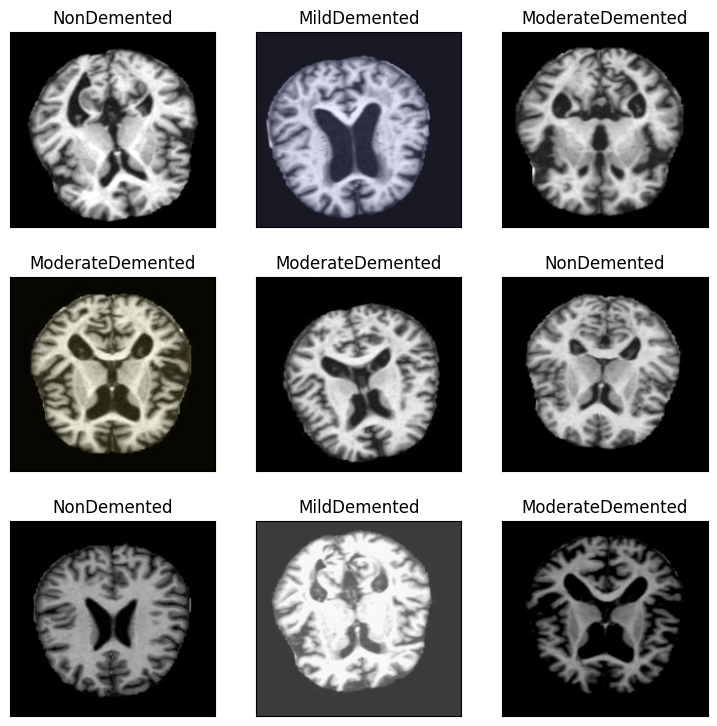

In [ ]:
plot_images(PATH)

In [ ]:
def plot_image_sizes(PATH):
  im_widths = []
  im_heights = []

  for dir in os.listdir(PATH):
    for dir_2 in os.listdir(PATH+dir+"/"):
      for image_file in glob.glob(PATH+dir+"/"+dir_2+"/*.jpg"):
        image = np.array(Image.open(image_file))
        dimensions = image.shape
        im_heights.append(dimensions[0])
        im_widths.append(dimensions[1])

  plt.scatter(im_widths,im_heights)
  plt.xlabel("Image Width")
  plt.ylabel("Image Height")
  plt.title("Image Dimensions for the Entire Dataset")

  h_values, h_counts = np.unique(im_heights, return_counts=True)
  w_values, w_counts = np.unique(im_widths, return_counts=True)

  print(f"Unique heights: {h_values} | # of occurences of each {h_counts}")
  print(f"Unique widths: {w_values} | # of occurences of each {w_counts}")
  
  print(f"")

In [ ]:
plot_image_sizes("/content/data/")

NOTE: This method tells us that the unique width and height combinations in our list are (180x180), (190x200), and (176x208). The most common size is (190x200). This tells me an image size of (256x256) shouldn't impact the data too much as sizes are around there

**END OF EDA**\
**Conclusions:**


*   Training data is well balanced and shouldn't negatively impact model
*   Images are able to be correctly shown and were loaded in correctly
*   Ideal Image Size for this training should be (256x256) and there isn't much variance in image sizes





# Creating a Custom Dataset & DataLoader


---
With insights gained on the data it is time to prepare the data so that it can enter into a DataLoader and be trained on a machine learning model

This will involve


*   Creating a subclass of Pytorch's Dataset
*   Overriding __getitem__ and __len__
*   Transforming data into Tensors
*   putting data through a DataLoader and creating batches, shuffling, etc...

Source for creating custom dataset:
https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pathlib
from glob import iglob

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize( (256,256) ),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [ ]:
class AugmentedAlzheimerMRIDataset(Dataset):

  def __init__(self, target_dir, transforms=None):
    self.target_dir = target_dir

    self.image_paths = []
    for dir in os.listdir(target_dir):
      for img_path in glob.glob(target_dir+"/"+dir+"/"+"*.jpg"):
        self.image_paths.append(img_path)
    
    self.transforms = transforms
    self.classes = sorted(os.listdir(target_dir+"/"))
    self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}
    self.class_count = []
    self.class_count_dict = {}

  def load_image(self, idx):
    return Image.open(self.image_paths[idx]).convert("RGB")
  
  def class_counts(self):      
    PATH = self.target_dir

    for dir in os.listdir(PATH):
      target_dir = PATH + "/" + dir
      files = os.listdir(target_dir)
      count = len(files)
      self.class_count.append(count)

    return self.class_count
    
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, index):
    img = self.load_image(index)
    class_name = os.path.dirname(self.image_paths[index]).split("/",-1)[-1]
    class_idx = self.class_to_idx[class_name]

    if self.transforms:
      return self.transforms(img), class_idx
    else:
      return img, class_idx

In [ ]:
train_data = AugmentedAlzheimerMRIDataset(target_dir= r"/content/data/train/", 
                                          transforms=train_transforms)
test_data = AugmentedAlzheimerMRIDataset(target_dir= r"/content/data/val/",
                                         transforms=test_transforms)

train_data, test_data

(<__main__.AugmentedAlzheimerMRIDataset at 0x7f7006230100>,
 <__main__.AugmentedAlzheimerMRIDataset at 0x7f7007e5c160>)

In [ ]:
train_data.classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
test_data.class_counts()

[64, 896, 2240, 3200]

In [ ]:
len(train_data), len(test_data)

(33984, 6400)

Looks like the Custom Dataset is now properly created and we can put it into a DataLoader

In [ ]:
#Hyper Parameters
BATCH_SIZE=16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f7006231e70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7006231600>)

The Dataset and the DataLoader should be created now, and everything seems to be working fine. It is now time to finally create the model and train the data

# Creating the Model

We are going to be trying a variety of models in this sections

We will test:
*   CNNs (ResNet50)
*   Ensemble Learning
*   Vision Transformers

This will involve:


*   Creating the Model Class or Importing
*   Setting up the criterion and optimizer
*   Creating a training loop
*   Train the Model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
###
# Load the pretrained model from pytorch
#model = models.resnet101()

# Newly created modules have require_grad=True by default
#num_features = model.fc.in_features
#features = list(model.fc.children())[:-1] # Remove last layer
#features.extend([nn.Linear(num_features, 4)]) # Add our layer with 4 outputs
#model.fc = nn.Sequential(*features) # Replace the model classifier

#model = model.to(device)

#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)
###

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(
      self,
      in_channels=3,
      embedding_dim=768,
      patch_size=16,
  ):
    super().__init__()
    self.in_channels=in_channels
    self.patch_size=patch_size
    self.embedding_dim=embedding_dim

    self.patch = nn.Conv2d(in_channels=self.in_channels,
                           out_channels=self.embedding_dim,
                           kernel_size=self.patch_size,
                           stride=self.patch_size)
    
    self.flatten = nn.Flatten(2,3)

  def forward(self, x):
    x = self.patch(x)
    x = self.flatten(x)
    x = x.permute(0,2,1)

    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,
               layers=12,
               embedding_dim=768,
               mlp_size=3072,
               n_heads=12,
               img_size=224,
               dropout=0.1,
               n_classes=4,
               patch_size=16,
               batch_size=32,
               ):
    super().__init__()

    self.n_layers = layers
    self.embedding_dim = embedding_dim
    self.mlp_size = mlp_size
    self.n_heads = n_heads
    self.img_size=img_size
    self.dropout=dropout
    self.n_classes=n_classes
    self.patch_size=patch_size
    self.batch_size=batch_size

    #Embed Patches
    self.embedded_patches = PatchEmbedding()

    #positional embed
    self.positional_embed = nn.Parameter(torch.randn(
        1,((img_size**2)//(patch_size**2))+1,embedding_dim
    ), requires_grad=True)

    #Transformer Encoding Layer
    self.encoding_layer = nn.TransformerEncoderLayer(d_model=self.embedding_dim,
                                                     nhead=self.n_heads,
                                                     dim_feedforward=self.mlp_size,
                                                     dropout=self.dropout,
                                                     activation="gelu",
                                                     batch_first=True,
                                                     norm_first=True,
                                                     )
    
    #Transformer Encoder
    self.encoder = nn.TransformerEncoder(self.encoding_layer,
                                         num_layers=self.n_layers,)
    
    #class token
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim), requires_grad=True)

    #mlp head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=n_classes)
    )
  
  def forward(self, x):
    x = self.embedded_patches(x)
    
    class_token = self.class_token.expand(self.batch_size, -1,-1)

    x = torch.cat((class_token, x), dim=1)

    x = self.positional_embed + x

    x = self.encoder(x)

    x = self.mlp_head(x[:,0])

    return x

In [ ]:
vision_transformer = VisionTransformer(img_size=256, batch_size=BATCH_SIZE, n_classes=len(train_data.classes)).to(device)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

In [ ]:
vision_transformer(image_batch).argmax(dim=1)

tensor([1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1], device='cuda:0')

In [ ]:
model_c = vision_transformer

In [ ]:
model_c

VisionTransformer(
  (embedded_patches): PatchEmbedding(
    (patch): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (encoding_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=3072, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=3072, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=

In [ ]:
try:
  import torchmetrics
  assert("Not installed")

except:
  !pip install torchmetrics
  import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.0 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

metric = MulticlassAccuracy(num_classes=len(test_data.classes)).to(device)

**Multiclass F1**

*Precision(class = a) = TP(class=a)/(TP(class=a)+FP(class=a))*

*Recall(class = a) = TP(class=a)/(TP(class=a)+FN(class=a))*

*F-1 Score(class=a) = 2*Precision(class=a) * Recall(class=a) / (Precision(class=a) + Recall(class=a))*


Source for equations: https://www.baeldung.com/cs/multi-class-f1-score

In [ ]:
f1 = MulticlassF1Score(num_classes=len(train_data.classes), average="weighted").to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.5)
optimizer = torch.optim.AdamW(model_c.parameters(),lr=1e-4, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5,)

In [ ]:
epoch_counter = 0

In [ ]:
checkpoint = torch.load(r"/content/gdrive/MyDrive/Colab_Notebooks/Alzheimer_SavedModels/vision_transformer_checkpoint_epoch_15.pth")
model_c.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch_counter = checkpoint["epoch"]
loss = checkpoint["loss"]

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 20 - epoch_counter

train_losses = []
train_accuracies = []
train_F1s = []

test_losses = []
test_accuracies = []
test_F1s = []

model_c.to(device)
for epoch in tqdm(range(EPOCHS)):

  print(f"Epoch: {epoch}"+"\n"+"-"*10)

  train_loss = 0
  train_acc = 0
  train_f1 = 0

  if epoch%5==0:
    print("Checkpointing model at epoch:"+str(epoch_counter))
    torch.save({
            'epoch': epoch_counter,
            'model_state_dict': model_c.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, "/content/gdrive/MyDrive/Colab_Notebooks/Alzheimer_SavedModels/vision_transformer_checkpoint_epoch_"+str(epoch_counter)+".pth")
    
  model_c.to(device)
  for batch, (X,y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model_c.train()
    y_pred = model_c(X)
    loss = loss_fn(y_pred, y)
    train_loss+=loss

    acc = metric(y_pred.argmax(dim=1), y)
    train_acc+=acc

    f1_score = f1(y_pred.argmax(dim=1), y)
    train_f1+=f1_score

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss/=len(train_dataloader)
  train_acc/=len(train_dataloader)
  train_acc*=100
  train_f1/=len(train_dataloader)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  train_F1s.append(train_f1)

  test_loss = 0
  test_acc = 0
  test_f1 = 0

  model_c.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model_c(X_test)
      test_loss += loss_fn(test_pred, y_test)

      t_acc = metric(test_pred.argmax(dim=1), y_test)
      test_acc+=t_acc

      t_f1 = f1(test_pred.argmax(dim=1), y_test)
      test_f1+=t_f1

    test_loss/=len(test_dataloader)
    test_acc/=len(test_dataloader)
    test_acc*=100
    test_f1/=len(test_dataloader)

  test_losses.append(test_loss)
  test_accuracies.append(test_acc)
  test_F1s.append(test_f1)

  scheduler.step(test_loss)
  epoch_counter+=1

  print(f"\nTrain loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}% | Train f1: {train_f1:.4f} | \nTest loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}% | Test F1: {test_f1:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------
Checkpointing model at epoch:10

Train loss: 1.2707 | Train Accuracy: 60.9955% | Train f1: 0.5974 | 
Test loss: 1.2461 | Test Accuracy: 16.4414% | Test F1: 0.7810
Epoch: 1
----------
Train loss isn't lowering, not checkpointing model at epoch11

Train loss: 1.2635 | Train Accuracy: 62.7484% | Train f1: 0.6153 | 
Test loss: 1.2292 | Test Accuracy: 17.5977% | Test F1: 0.8191
Epoch: 2
----------
Train loss isn't lowering, not checkpointing model at epoch12

Train loss: 1.2584 | Train Accuracy: 63.6096% | Train f1: 0.6283 | 
Test loss: 1.2160 | Test Accuracy: 17.8945% | Test F1: 0.8230
Epoch: 3
----------
Train loss isn't lowering, not checkpointing model at epoch13

Train loss: 1.2516 | Train Accuracy: 65.4406% | Train f1: 0.6462 | 
Test loss: 1.2059 | Test Accuracy: 18.6445% | Test F1: 0.8442
Epoch: 4
----------
Train loss isn't lowering, not checkpointing model at epoch14

Train loss: 1.2457 | Train Accuracy: 66.4476% | Train f1: 0.6584 | 
Test loss: 1.2023 | Test Ac

NameError: ignored

In [ ]:
with torch.inference_mode():
  plt.title("Train Loss vs Test Loss")
  plt.plot([train_loss.to("cpu") for train_loss in train_losses])

  plt.plot([test_loss.to("cpu") for test_loss in test_losses])
  plt.show()